In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from itertools import product
import math
import random
import matplotlib.pyplot as plt

from utils import FourierDataset, ModelTrainer

random_seed = 0
torch.manual_seed(random_seed)
random.seed(random_seed)

/local/agorji/minconda3/envs/spectral/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test WH transform

In [152]:
test_k = 10
test_n = 100
test_b = 8
test_d = 5
test_n_samples = 100

test_ds = FourierDataset(n=test_n, k=test_k, d=test_d, n_samples=test_n_samples)

In [153]:
print(torch.sum(test_ds.amp_f**2)/2**test_b)
print(torch.mean(test_ds.amp_f))
print(torch.mean(torch.abs(test_ds.amp_f)))
print(torch.std(test_ds.y * test_k / torch.sum(torch.abs(test_ds.amp_f)**2)))
print(torch.mean(test_ds.y))
print(test_ds.y)

tensor(0.0139)
tensor(0.0324)
tensor(0.5456)
tensor(0.5133)
tensor(-0.0208)
tensor([-0.2913, -0.0081, -0.2635, -0.2320, -0.0660, -0.3493, -0.2274, -0.0472,
         0.1585, -0.1915, -0.3323,  0.0477,  0.0250,  0.1130, -0.0913, -0.4174,
        -0.2759, -0.2635, -0.1998, -0.0226, -0.2320,  0.1327, -0.0584, -0.2135,
         0.0679,  0.3728, -0.1269,  0.1154,  0.0470, -0.1635, -0.0601,  0.0031,
         0.1966,  0.2596,  0.3459,  0.1964,  0.0089,  0.0348,  0.0413, -0.1585,
        -0.1154,  0.0696, -0.1816, -0.0722,  0.0486,  0.0922, -0.0122, -0.1785,
        -0.5223,  0.2312, -0.0493,  0.0291, -0.2215,  0.1509,  0.2642, -0.0152,
         0.1286,  0.0363, -0.2165, -0.0883,  0.0541,  0.1116,  0.1276,  0.1276,
         0.0348, -0.0226, -0.1181,  0.1352,  0.0729, -0.1051, -0.0591,  0.0356,
         0.2408, -0.2846,  0.2829,  0.1562, -0.3866,  0.1058, -0.1030,  0.4188,
         0.1254,  0.0152,  0.1204, -0.1585, -0.0906,  0.1101,  0.0186, -0.2508,
         0.1741, -0.2820,  0.1284, -0.0637, 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

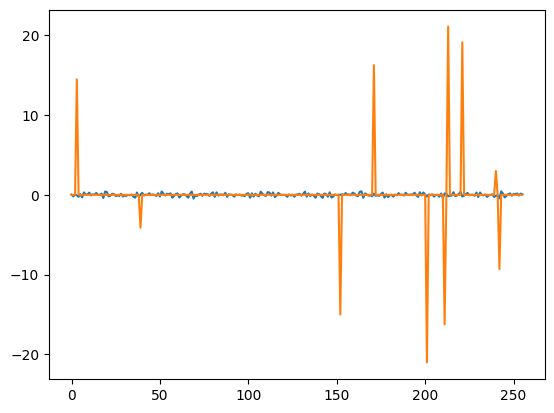

In [154]:
def hadamard_matrix(n, normalize=False):
    '''
    Compute H_n, Hadamard matrix
    '''
    H1 = torch.asarray([[1.,1.], [1.,-1.]])
    H = torch.asarray([1.])
    for i in range(n):
        H = torch.kron(H, H1)
    if normalize:
        H = (1 / math.sqrt(2**n)) * H
    return H

def get_sample_inputs(n, b):
    hash_sigma = (torch.rand(b, n) < 0.5).float() # multivariate bernouli with p=0.5
    hash_inputs = torch.asarray(list((product((0.0,1.0), repeat=b))))

    sample_inputs = (hash_inputs @ hash_sigma) % 2
    return sample_inputs

# hadamard_matrix(3, normalize=False)

sample_inputs = get_sample_inputs(test_n, test_b)
print(sample_inputs)

print(test_ds.freq_f)
print(test_ds.amp_f)
# all_inputs = torch.asarray(list((product((0.0,1.0), repeat=test_n))))
all_inputs = sample_inputs

landscape = test_ds.compute_y(all_inputs)
# landscape = landscape[torch.randperm(landscape.shape[0])]
H = hadamard_matrix(test_b, normalize=False)
spectrum = H @ landscape

plt.plot(list(range(2**test_b)), landscape.numpy())
plt.plot(list(range(2**test_b)), spectrum.numpy())

In [155]:
print(sorted(spectrum[np.abs(spectrum) > 1e-5]))
print(sorted(test_ds.amp_f / test_k * 2**test_b))
print(torch.sum(spectrum[np.abs(spectrum) > 1e-5]))
print(torch.sum(test_ds.amp_f / test_k * 2**test_b))
print(torch.mean(torch.abs(spectrum)))
print(torch.mean(torch.abs(test_ds.amp_f / test_k * 2**test_b)))

[tensor(-21.0217), tensor(-16.2390), tensor(-15.0083), tensor(-9.3047), tensor(-4.1145), tensor(2.9935), tensor(14.4906), tensor(16.2652), tensor(19.1347), tensor(21.1113)]
[tensor(-21.0217), tensor(-16.2390), tensor(-15.0083), tensor(-9.3047), tensor(-4.1145), tensor(2.9935), tensor(14.4906), tensor(16.2652), tensor(19.1347), tensor(21.1113)]
tensor(8.3071)
tensor(8.3071)
tensor(0.5456)
tensor(13.9684)


# Test Training Methods

In [4]:
n = 100
k = 100
d = 20
c = 5
n_samples = int(c * k * n * (4/3))
dataset = FourierDataset(n, k, d=d, n_samples=n_samples)
print(dataset.X.shape)
print(dataset.y)

torch.Size([66666, 100])
tensor([ 0.0836,  0.0121,  0.0086,  ...,  0.0310,  0.0391, -0.0200])


In [5]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

In [7]:
torch.manual_seed(random_seed)

train_config = {
    "training_method": "hashing",
    "add_hadamard_loss": True, 
    "SPRIGHT_m": 7,
    "SPRIGHT_d": 3,
    "rho": 0.01,
    "b": 10,
    "lr": 0.01, 
    "scheduler_step_size": 50,
    "scheduler_gamma": 1,
    "weight_decay": 0, 
    "hadamard_lambda": 1,
    "num_epochs": 200,
    "batch_size": 4096,
    "random_seed": 11,
}

in_dim = dataset.X.shape[1]
model = FCN(in_dim, 10, batch_norm=True)
trainer = ModelTrainer(model, dataset, train_config, plot_results=True)
log = trainer.train_model()

#0 - Train Loss: 3.364, R2: -907.630	Validation Loss: 0.177, R2: -46.572
#1 - Train Loss: 0.040, R2: -9.932	Validation Loss: 0.009, R2: -1.408
#2 - Train Loss: 0.005, R2: -0.466	Validation Loss: 0.004, R2: -0.081
#3 - Train Loss: 0.004, R2: -0.059	Validation Loss: 0.004, R2: -0.041
#4 - Train Loss: 0.004, R2: -0.055	Validation Loss: 0.004, R2: -0.028
#5 - Train Loss: 0.004, R2: -0.050	Validation Loss: 0.004, R2: -0.045
#6 - Train Loss: 0.004, R2: -0.066	Validation Loss: 0.005, R2: -0.241
#7 - Train Loss: 0.004, R2: -0.120	Validation Loss: 0.004, R2: -0.098
#8 - Train Loss: 0.004, R2: -0.084	Validation Loss: 0.004, R2: -0.140


KeyboardInterrupt: 

In [14]:
trainer.model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    RSS, TSS = 0, 0
    for X, y in trainer.val_loader:
        X, y = X.to('cuda'), y.to('cuda')
        y_hat = trainer.model(X)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(y_hat.cpu().numpy())

## Test hashing

/tmp/ipykernel_3656978/3025935720.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.sum(hash_rev == torch.tensor(hash_inputs[i, :]), axis=-1) == b


tensor([[1., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [1., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 1., 1., 0.],
        [0., 1

<BarContainer object of 64 artists>

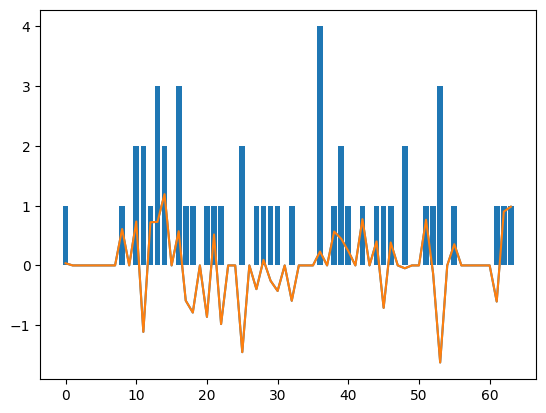

In [64]:
import copy

n = 12
k = 50
d = 5

main_signal = FourierDataset(n, k, d=d)
original_inputs = torch.asarray(list((product((0.0,1.0), repeat=n))))

# for b in range(2, n):
b = 6
H = hadamard_matrix(b, normalize=True)

# Hash
hash_sigma = (torch.rand(n, b) < 0.5).float() # multivariate bernouli with p=0.5
hash_inputs = torch.asarray(list((product((0.0,1.0), repeat=b))))
sample_inputs = hash_inputs @ torch.t(hash_sigma)
hash_landscape = main_signal.compute_y(sample_inputs)
hash_spectrum = (H @ hash_landscape) / ((2**(b/2))/k)

hash_rev = (main_signal.freq_f @ hash_sigma) % 2 # (sigma^t @ inputs^t)^t
hash_amps = torch.zeros(2**b)
hash_count = torch.zeros(2**b)
for i in range(2**b):
    mask = torch.sum(hash_rev == torch.tensor(hash_inputs[i, :]), axis=-1) == b
    hash_amps[i] = torch.sum(main_signal.amp_f[mask])
    hash_count[i] = torch.sum(mask)
print(hash_rev)
print(hash_rev.shape)
print(hash_amps)
print(hash_spectrum)
plt.plot(list(range(2**b)), hash_amps.numpy())
plt.plot(list(range(2**b)), hash_spectrum.numpy())
plt.bar(list(range(2**b)), hash_count.numpy())


# hashed_freqs = H @ main_signal.compute_y(sample_inputs)

    